## Run Algorithm 3 on stationary OU, with J imposed at middle and final time

In [21]:

import matplotlib.pyplot as plt
import numpy as np
import math


dim = 1
walkers = 200   # size of the interacting particle system
m = 30   # number of purturbations for FI estimator
sigma = 0.4   # size of perturbation


hyperparams={'dt': 0.02, 'num_steps': 50, 'num_training_steps' : 3000}

# OU as reference: dXt = - beta X_t dt + sqrt{2}dW_t
# stationary distribution \nu is N(0,1/beta) with variance = 1/beta
beta = 0.25
X_init = np.random.normal(0,1/math.sqrt(beta),walkers)  # initialize walkers from Gaussian


grad_V = lambda x: beta*x   # gradient of reference potential
delta_log_nu = lambda x: -beta*dim    # constant in this case



Train loss: 3.53460454789456e-05
Train loss: 271.71514892578125
Train loss: 24.77165985107422
Train loss: 20.815799713134766
Train loss: 4.5460524559021
Train loss: 34.53226852416992
Train loss: 2.377439498901367
Train loss: 2.909226179122925
Train loss: 3.311502695083618
Train loss: 27.79462242126465
Train loss: 2.541738986968994
Train loss: 3.162752151489258
Train loss: 2.8225924968719482
Train loss: 3.4173004627227783
Train loss: 3.32649564743042
Train loss: 2.765460729598999
Train loss: 2.564880609512329
Train loss: 1.9700303077697754
Train loss: 3.974637031555176
Train loss: 2.16141676902771
Train loss: 4.1440815925598145
Train loss: 2.675042152404785
Train loss: 1.670989751815796
Train loss: 4.746021270751953
Train loss: 3.0870983600616455
Train loss: 4.496110916137695
Train loss: 1342.9771728515625
Train loss: 3.410778284072876
Train loss: 2.548887252807617
Train loss: 3.305154800415039
Train loss: 4.885297775268555
Train loss: 2.8828375339508057
Train loss: 3.1282708644866943
T

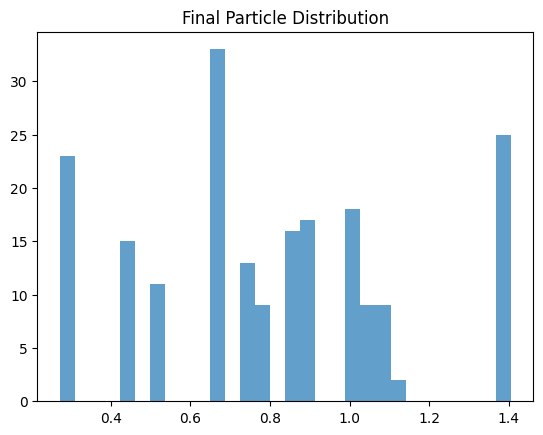

In [22]:
from collections import defaultdict
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import sys
sys.path.append("..")
from src.nn import MLP, train

key = jax.random.PRNGKey(0)

h = hyperparams['dt']
T = hyperparams['num_steps']*hyperparams['dt']
num_steps = hyperparams['num_steps']
num_training_steps = hyperparams['num_training_steps']

# Set up the neural network
mlp_dims = [3, 500, 500, 500, 500, 500, 500, 200, 1]
# mlp_dims = [3, 20, 20, 1]
model_key, key = jax.random.split(key)
phi = MLP(mlp_dims, key=model_key)
optimizer = optax.adam(1e-3)


# specify location and time of active likelihood
choice_points = jnp.array([0.5, 0.9]) # it only goes up to 0.98...probably a 0 indexing thing. important?
choice_location = jnp.array([-1.0, 1.0])


# likelihood function: x(middle_point)=-3, x(final_point)=3. So J is 0 for most t.
# without J, one expect N(0,1/beta) for all t
# tol = 0.1
tol = jnp.array([0.4, 0.1])


# Initialize particles
X_particles = jnp.array(X_init).reshape(-1, 1)  # shape (n, 1)

## train phi to be the identity function
def identity_loss(phi, X, t, s):
    return jnp.mean(jax.vmap(lambda x: (phi(x, t, s)-x)**2)(X))


phi = train(identity_loss, phi, optimizer, num_training_steps, X_particles, jnp.ones((1,))*0.0, jnp.ones((1,)))


# plot input to output of phi
#plt.plot(X_particles, jax.vmap(lambda x: phi(x, jnp.ones((1,))*0.0, jnp.ones((1,)))[0])(X_particles))
#plt.show()


# define loss function
def L_theta(X, grad_V):
    # delta_log_nu(x) = -\beta
    return jnp.mean(jax.vmap(lambda x: 0.5 * jnp.linalg.norm(grad_V(x))**2 - beta )(X))


def R_theta(X, m, sigma, key):
    X = jnp.expand_dims(X, axis=0)
    n = X.shape[0]
    Y = X + sigma * jax.random.normal(key, (m, n))
    diff = Y - X
    return jnp.mean(jax.vmap(lambda k: jnp.linalg.norm(k)**2 / (2 * sigma ** 4))(diff))

def J_t(X,t):
    t_condition = jnp.any(t==choice_points)
    t_index = jnp.nonzero(t==choice_points, size=1)[0]
    # jax.debug.print("choice {x}", x=(t_index, t))
    #t_condition * ((1/2.0)*(1/tol**2)*(X[0] - 3)**2)
    return t_condition * ((1/2.0)*(1/tol[t_index]**2)*(X[0] - choice_location[t_index])**2)

def make_loss(rkey):
    def loss(phi, X, t, s):
        X_proposed = jax.vmap(jax.grad(lambda x: phi(x,  t, s)[0]))(X)
        term1 =  (1/(2*h**2)) * (jnp.mean(jax.vmap(lambda x,y: (x-y).dot(x-y))(X_proposed, X)))
        term2 = jnp.mean(jax.vmap(lambda x: R_theta(x, m, sigma, rkey) + (2/h)*J_t(x, t))(X_proposed))
        #term2 = jnp.mean(jax.vmap(lambda x: (2/h)*J_t(x, t))(X_proposed))
        term3 = L_theta(X_proposed, grad_V)
        return term1 + term2 + term3
    return loss


trajectories = []

# Main loop
for step in range(num_steps):
    t = step * h
    t_input = jnp.ones((1,)) * t
    s_input = jnp.ones((1,)) # a placeholder variable

    trajectories.append(X_particles)

    rkey = jax.random.fold_in(key, step)

    # new phi: but is it phi(\cdot, x)?
    #print(identity_loss(phi, X_particles, jnp.ones((1,))*t, jnp.ones((1,))))
    phi = train(make_loss(rkey), phi, optimizer, num_training_steps, X_particles, jnp.ones((1,))*t, s_input)

    X_particles = jax.vmap(jax.grad(lambda x: phi(x,  t_input, s_input)[0]))(X_particles)


# After loop, X_particles contains the final samples
plt.hist(np.array(X_particles).flatten(), bins=30, alpha=0.7)
plt.title('Final Particle Distribution')
plt.show()

(50, 200)


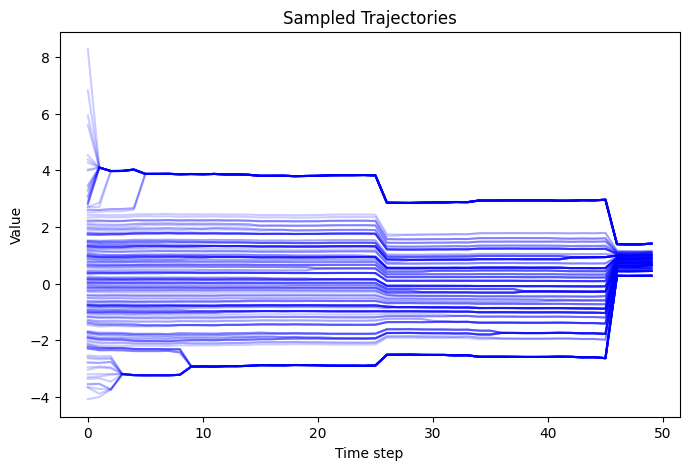

In [23]:

# sigma=0.6

plotted_trajectories = jnp.array(trajectories)[:,:,-1]
print(plotted_trajectories.shape)


plt.figure(figsize=(8, 5))
for traj in plotted_trajectories.T:
    plt.plot(range(len(traj)), traj, color='blue', alpha=0.2)  # low alpha for overlap

plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Sampled Trajectories')
#plt.ylim([-2, 2])
plt.show()


In [100]:
plotted_trajectories.shape

(50, 200)

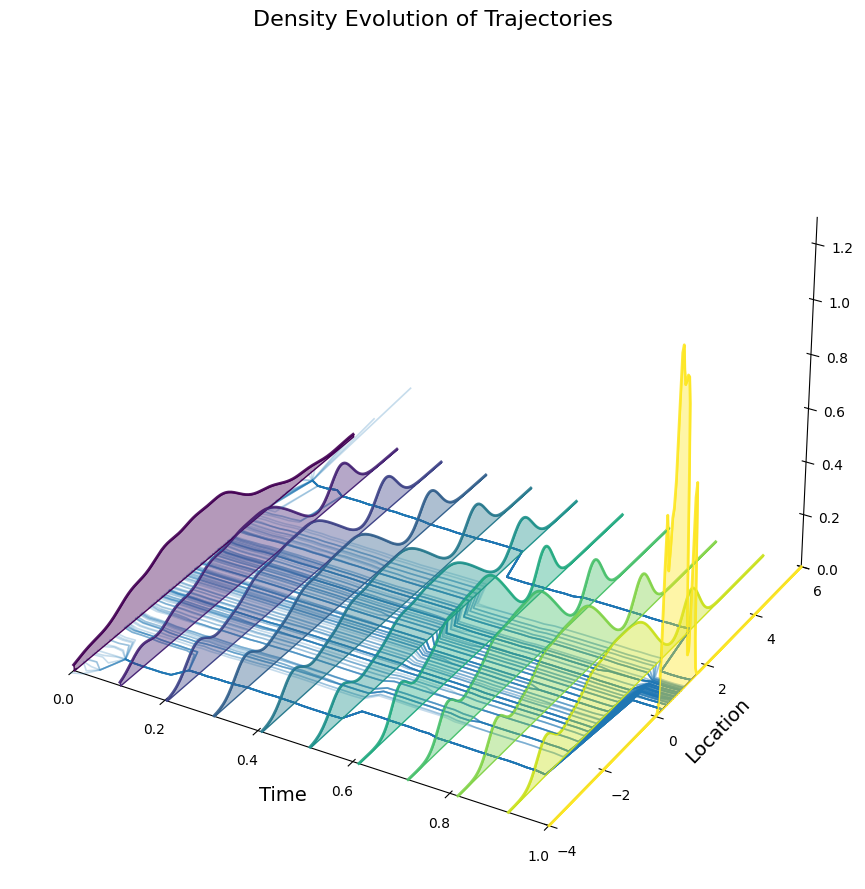

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from scipy.stats import gaussian_kde
import seaborn as sns


def plot_3d_density_and_trajectories(plotted_trajectories, step=5, x_min=-4, x_max=6):
    n_steps, n_paths = plotted_trajectories.shape
    x_grid = np.linspace(x_min, x_max, 200)
    # Scale time to [0, 1]
    t_grid = np.linspace(0, 1, n_steps)

    fig = plt.figure(figsize=(20, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Remove the grey background cube (modern matplotlib)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo['grid']['color'] = (1,1,1,0)
    ax.yaxis._axinfo['grid']['color'] = (1,1,1,0)
    ax.zaxis._axinfo['grid']['color'] = (1,1,1,0)

    # Color map for time
    cmap = plt.get_cmap('viridis')
    color_norm = plt.Normalize(0, n_steps-1)

    # Plot densities as ridges and fill under them
    selected_ts = list(range(0, n_steps, step))
    if (n_steps-1) not in selected_ts:
        selected_ts.append(n_steps-1)  # Ensure last step is included

    for idx, t_idx in enumerate(selected_ts):
        t = t_grid[t_idx]
        values = plotted_trajectories[t_idx, :]
        kde = gaussian_kde(values, bw_method=0.2)
        density = kde(x_grid)
        color = cmap(color_norm(t_idx))
        # Ridge line: t is x, x_grid is y, density is z
        ax.plot([t]*len(x_grid), x_grid, density, color=color, alpha=0.9, lw=2)
        # Fill under the curve
        verts = [list(zip([t]*len(x_grid), x_grid, density))]
        verts[0].append((t, x_grid[-1], 0))
        verts[0].insert(0, (t, x_grid[0], 0))
        poly = art3d.Poly3DCollection(verts, color=color, alpha=0.4)
        ax.add_collection3d(poly)

    # Plot trajectories (as more visible lines on the ground)
    for i in range(n_paths):
        ax.plot(t_grid, plotted_trajectories[:, i], zs=0, zdir='z', alpha=0.25, lw=1.2, color='tab:blue')

    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Location', fontsize=14)
    ax.set_zlabel('', fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(x_min, x_max)
    ax.set_zlim(0, None)
    ax.grid(False)
    ax.set_title('Density Evolution of Trajectories', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_3d_density_and_trajectories(plotted_trajectories)
